# Dynamically select warm/growing season

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask 


from dataclasses import dataclass, field

import datetime

from scipy.optimize import least_squares
from scipy.ndimage import label

from sklearn.metrics import r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import cmocean


import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# progress bars for loops
from tqdm.notebook import tqdm  

import traceback

import time

from os.path import exists



In [2]:
## import my utils
from climate_utils import global_mean


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Import Data & process data

- selects region
- selects variables
- converts units

In [4]:
dict_ds = {'MERRA2': {},
        'NLDAS_NOAH': {}, 
        'NLDAS_MOS': {}
       }

In [5]:
model_params = {'MERRA2': {'model_dir': 'MERRA/', 
                           'filename': 'MERRA2_100th_meridian_west_land_1980-2025.nc', 
                           'p_var': 'PRECTOTLAND', 
                           't_var': 'T2MMEAN',
                           'sf_var': 'SFMC',
                           'rz_var': 'RZMC',
                           'snowfall_var': 'PRECSNOLAND', 
                           'snowdepth_var': 'SNODP'          
                          },
                'NLDAS_NOAH': {'model_dir': 'NLDAS/', 
                           'filename': 'NLDAS_NOAH_1979-2024.nc', 
                           'p_var': 'Rainf', 
                           't_var': 'Tair', 
                           'sf_var': 'SoilM_0_10cm',
                           'rz_var': 'SoilM_0_100cm',
                           'snowfall_var': 'Snowf', 
                           'snowdepth_var': 'SnowDepth'          
                          }, 
                 'NLDAS_MOS': {'model_dir': 'NLDAS/', 
                           'filename': 'NLDAS_MOS_1979-2024.nc', 
                           'p_var': 'Rainf', 
                           't_var': 'Tair', 
                           'sf_var': 'SoilM_0_10cm',
                           'rz_var': 'SoilM_0_100cm',
                           'snowfall_var': 'Snowf', 
                           'snowdepth_var': 'SnowDepth'          
                          }
               }
                 


## Select soil moisture variable

In [6]:
for model in model_params.keys():
    model_params[model]['s_var'] = model_params[model]['sf_var']
    #model_params[model]['s_var'] = model_params[model]['rz_var']



In [8]:
processed_data_dir = '/Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/'
fig_save_dir = '/Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/figures/tidy/'
nc_save_dir = '/Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/filtered_seasons/'

for model in tqdm(dict_ds.keys()):
    print(model)
        
    dict_ds[model] = xr.open_mfdataset(processed_data_dir + model_params[model]['model_dir'] + model_params[model]['filename'], 
                         parallel = True).load()


  0%|          | 0/3 [00:00<?, ?it/s]

MERRA2
NLDAS_NOAH
NLDAS_MOS


In [9]:
## for 100th meridien
lats = [25, 50]
lons = [-130, -100]

dict_ds_region = {}

for model in tqdm(dict_ds.keys()):

    dict_ds_region[model] = dict_ds[model][[model_params[model]['sf_var'], 
                                            model_params[model]['rz_var'], 
                                            model_params[model]['t_var'], 
                                            model_params[model]['p_var'], 
                                            model_params[model]['snowfall_var'], 
                                            model_params[model]['snowdepth_var']]].sel(lon = slice(lons[0], lons[1]), 
                                                                                       lat = slice(lats[0],  lats[1])).sel(time = slice('1980', '2023'))

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
def units_convert(ds, var, printout = True):
    ds = ds.copy()

    ### we want precipitation units in mm day-1
    if var in ('precipitation', 'pr', 
               'PRECTOTLAND', 'PRECSNOLAND', 'RUNOFF', 'QINFIL', 'EVLAND', 
               'Rainf', 'Snowf'):

        if ds[var].attrs['units'] != 'mm day-1':
            if printout == True:
                print('converting ' + model + ' with ' + var + ' units ' + str(ds[var].attrs['units']) + ' to mm day-1')
            
            if ds[var].attrs['units'] == 'cm day-1':
                ds[var] = ds[var] * 10 
                ds[var].attrs['units'] = 'mm day-1'
            
            if ds[var].attrs['units'] == 'kg m-2 s-1':
                ds[var] = ds[var] * 86400
                ds[var].attrs['units'] = 'mm day-1'

            if ds[var].attrs['units'] == 'kg m-2':
                ## this is equivalent to mm, so just need to change attrs
                ds[var].attrs['units'] = 'mm day-1'
            
    ### we want soil moisture units in kg m-2            
    if var in ('SMsurf', 'SMroot', 'mrsos', 'mrsol', 'SFMC', 'RZMC', 'SoilM_0_10cm', 'SoilM_0_100cm'):
        
        if ds[var].attrs['units'] != 'kg m-2':
            if printout == True:
                print('converting ' + model + ' with ' + var + ' units ' + str(ds[var].attrs['units']) + ' to kg m-2')
            
            
            if ds[var].attrs['units'] in ('m3.m-3', 'm-3 m-3'):
                if (model == 'GLEAM') & (var == 'SMsurf'):
                    ## GLEAM's surface soil moisture is 10cm or 100mm deep
                    ## convert to mm using a 100 mm (0.1 m) soil depth
                    depth = 100 #mm
                    
                if (model in ['MERRA2','MERRA2-precip_minus_snow', 'MERRA2-precip_minus_snow_runoff']) & (var == 'SFMC'):
                    ## MERRA2's surface soil moisture is 5cm or 50mm deep
                    ## convert to mm using a 50 mm (0.05 m) soil depth
                    depth = 50 #mm
                    
                if (model in ['MERRA2', 'MERRA2-precip_minus_snow', 'MERRA2-precip_minus_snow_runoff']) & (var == 'RZMC'):
                    ## MERRA2's rootzone soil moisture is 100cm or 1000mm deep
                    ## convert to mm using a 1000 mm (1 m) soil depth
                    depth = 1000 #mm
                    
                ### m3/m3 * depth
                ds[var] = ds[var] * depth    
                ds[var].attrs['units'] = 'kg m-2' 
                
                ## additional printouts
                #if printout == True:
                #    print('converted ' + model + ' with ' + var + ' units ' + str(ds[var].attrs['units']) + 'to kg m-2')


    ### we want temperature units in ºC
    if var in ('TSURF', 'Tair', 'T2MMEAN'):
        if ds[var].attrs['units'] != 'ºC':
            print('converting ' + model + ' with ' + var + ' units ' + str(ds[var].attrs['units']) + ' to ºC')
            if ds[var].attrs['units'] == 'K':
                zeroCelsius = -272.15
                ds[var] = ds[var] + zeroCelsius
                ds[var].attrs['units'] = 'ºC'
                
    return ds

In [11]:
### may need to adjust this when running on new models
for model in tqdm(dict_ds_region.keys()):
    ds_region = dict_ds_region[model]

    ds_region = units_convert(ds_region, model_params[model]['p_var'], printout = True)
    ds_region = units_convert(ds_region, model_params[model]['sf_var'], printout = True)
    ds_region = units_convert(ds_region, model_params[model]['rz_var'], printout = True)
    ds_region = units_convert(ds_region, model_params[model]['snowfall_var'], printout = True)
    ds_region = units_convert(ds_region, model_params[model]['t_var'], printout = True)

    dict_ds_region[model] = ds_region

  0%|          | 0/3 [00:00<?, ?it/s]

converting MERRA2 with PRECTOTLAND units kg m-2 s-1 to mm day-1
converting MERRA2 with SFMC units m-3 m-3 to kg m-2
converting MERRA2 with RZMC units m-3 m-3 to kg m-2
converting MERRA2 with PRECSNOLAND units kg m-2 s-1 to mm day-1
converting MERRA2 with T2MMEAN units K to ºC
converting NLDAS_NOAH with Rainf units kg m-2 to mm day-1
converting NLDAS_NOAH with Snowf units kg m-2 to mm day-1
converting NLDAS_NOAH with Tair units K to ºC
converting NLDAS_MOS with Rainf units kg m-2 to mm day-1
converting NLDAS_MOS with Snowf units kg m-2 to mm day-1
converting NLDAS_MOS with Tair units K to ºC


In [12]:
### Filter T2MMEAN properly 
dict_ds_region['MERRA2']['T2MMEAN'] = dict_ds_region['MERRA2'][model_params['MERRA2']['t_var']].where(~np.isnan(dict_ds_region['MERRA2'][model_params['MERRA2']['s_var']]))

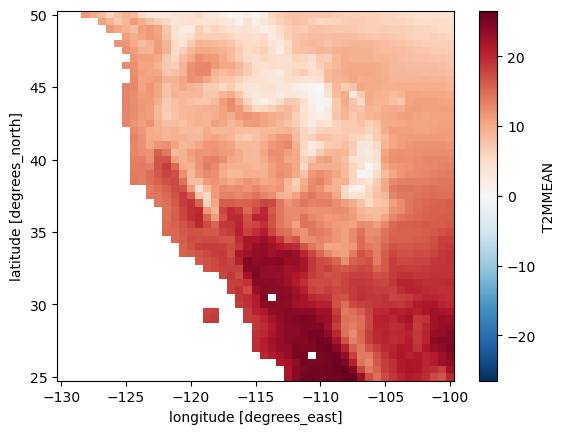

In [13]:
model = 'MERRA2'
dict_ds_region[model][model_params[model]['t_var']].mean(dim = 'time').plot()

## Filtering by season

In [17]:
def filter_longest_warm_season(temp, snowfall, snowdepth, var, time):
    """
    Filters the longest warm season period for a single pixel across multiple years.
    """
    # Convert time to NumPy datetime64 if not already
    time = np.array(time, dtype="datetime64")
    years = np.unique(time.astype("datetime64[Y]"))
    result = []

    for year in years:
        # Extract data for the year
        year_mask = (time >= year) & (time < year + np.timedelta64(1, "Y"))
        temp_year = temp[year_mask]
        snowfall_year = snowfall[year_mask]
        snowdepth_year = snowdepth[year_mask]
        var_year = var[year_mask]
        time_year = time[year_mask]

        # Create a warm season mask
        # where temperature > 0, snowfall == 0, snowdepth <= 0.001 (this is because NLDAS NOAH has confusing snowdepth accumulation)
        warm_season_mask = (temp_year > 0) & (snowfall_year == 0) & (snowdepth_year <= 0.001)
        labels, num_labels = label(warm_season_mask)

        if num_labels == 0:
            # No valid periods in this year
            result.append(np.full_like(var_year, np.nan))
            continue

        # Find the longest valid period
        lengths = np.array([(labels == i).sum() for i in range(1, num_labels + 1)])
        longest_label = np.argmax(lengths) + 1

        # Select the longest period
        longest_period_mask = labels == longest_label
        result.append(np.where(longest_period_mask, var_year, np.nan))

    return np.concatenate(result)

def filter_warm_season(ds, model, model_params):
    """
    Filters the dataset to retain only the longest warm season in each year.
    Preserves units and other attributes for all variables.
    """
    # Apply the filtering function
    filtered = xr.apply_ufunc(
        filter_longest_warm_season,
        ds[model_params[model]['t_var']], ds[model_params[model]['snowfall_var']], ds[model_params[model]['snowdepth_var']], ds[model_params[model]['s_var']], ds['time'],
        input_core_dims=[["time"], ["time"], ["time"], ["time"], ["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",  # Enables parallel computation with dask
    )

    # Create a copy of the dataset to preserve other variables and attributes
    ds_filtered = ds.copy()

    # Replace the s_var data in the filtered dataset with the filtered data
    ds_filtered[model_params[model]['s_var']] = filtered

    for var_name in ds.data_vars:
        if var_name != model_params[model]['s_var']: 
            # Apply the same filter mask to other variables
            ds_filtered[var_name] = ds[var_name].where(~ds_filtered[model_params[model]['s_var']].isnull(), drop=True)
            # Preserve the attributes for all variables
        ds_filtered[var_name].attrs = ds[var_name].attrs

    return ds_filtered

In [19]:
dict_ds_warm_season = {}

for model in tqdm(dict_ds_region.keys()):
    
    file_save_loc = f"{nc_save_dir}{model}_warm-season_{dict_ds_region[model].time.dt.year.min().values}-{dict_ds_region[model].time.dt.year.max().values}.nc"

    ## calculate seasons /or/ open file if it exists
    if exists(file_save_loc):
        print(f'{model} warm seasons file already exist, importing')
        dict_ds_warm_season[model] = xr.open_dataset(file_save_loc)

    else:
        print(f'starting {model}')
        ds = dict_ds_region[model]
        dict_ds_warm_season[model] = filter_warm_season(ds, model, model_params)

        print(f'saving {model}')
        dict_ds_warm_season[model].to_netcdf(file_save_loc)
        print(f"{model} saved to {file_save_loc}")
    

  0%|          | 0/3 [00:00<?, ?it/s]

MERRA2 warm seasons file already exist, importing
starting NLDAS_NOAH
saving NLDAS_NOAH
NLDAS_NOAH saved to /Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/filtered_seasons/NLDAS_NOAH_warm-season_1980-2023.nc
starting NLDAS_MOS
saving NLDAS_MOS
NLDAS_MOS saved to /Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/filtered_seasons/NLDAS_MOS_warm-season_1980-2023.nc


### Rough plot of the length of the warm season

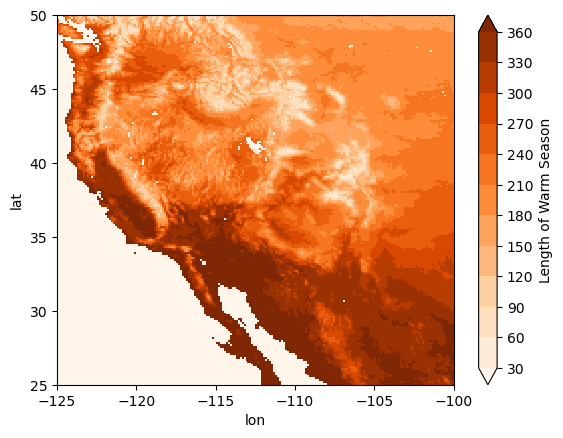

In [25]:
levels = [30, 60, 90, 120, 150, 180, 210,  240, 270, 300, 330, 360]
dict_ds_warm_season[model].groupby('time.year').count().mean(dim = 'year')[model_params[model]['t_var']].plot(vmin = 30, 
                                                                                                              vmax = 360, 
                                                                                                              levels = 12, 
                                                                                                              cmap = 'Oranges',
                                                                                                              cbar_kwargs={'label': 'Length of Warm Season', 
                                                                                                                           'ticks': levels})